In [2]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from source.PrototypeSelector import PrototypeSelector
from source.knn import KNNParzen
from sklearn.datasets import load_breast_cancer
from source.utils import leave_one_out_cross_validation, plot_results

Загрузка датасета breast cancer Wisconsin dataset (classification).

In [3]:
X, Y = load_breast_cancer(return_X_y=True)
Y[Y == 0] = -1

# Масштабирование данных
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(f"X shape: {X.shape}")
print(f"y shape: {Y.shape}")
print(f"Classes: {np.unique(Y)}")

X shape: (569, 30)
y shape: (569,)
Classes: [-1  1]


Визуализация плотности распределения

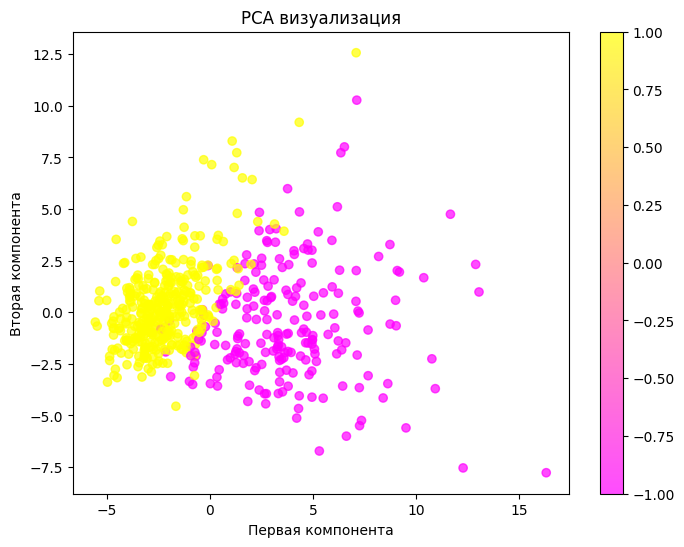

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=Y, cmap='spring', alpha=0.7)
plt.colorbar()
plt.title('PCA визуализация')
plt.xlabel('Первая компонента')
plt.ylabel('Вторая компонента')
plt.show()

Оптимизация параметра k методом LOO, k из диапазона [1, 14].

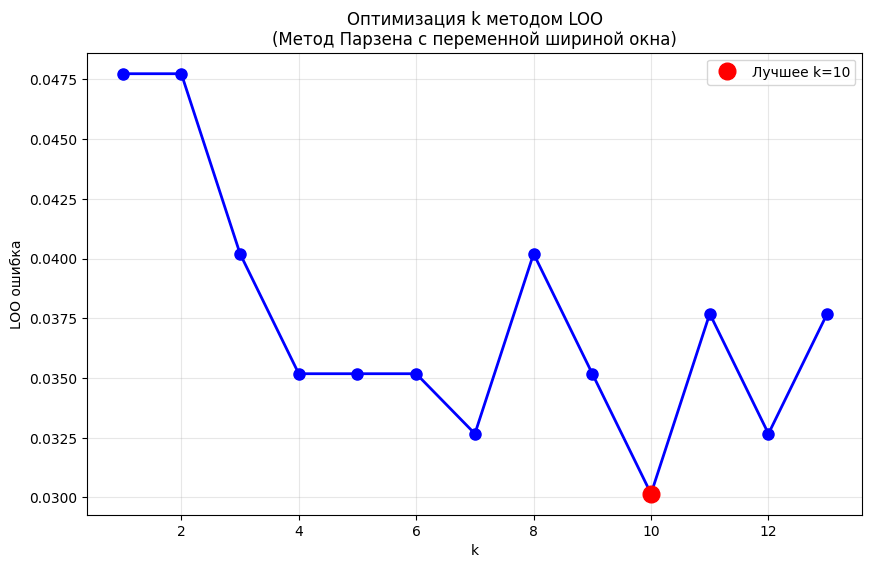

   Оптимальный параметр k: 10 (LOO ошибка: 0.0302)



In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

model = KNNParzen()

k_values = list(range(1, 14))
loo_scores = leave_one_out_cross_validation(model, X_train, y_train, k_values)

best_k, best_loo_score = plot_results(k_values, loo_scores,
                                      'Оптимизация k методом LOO\n(Метод Парзена с переменной шириной окна)')
print(f"   Оптимальный параметр k: {best_k} (LOO ошибка: {best_loo_score:.4f})\n")



Отбор эталонов методом удаления неэталонных объектов.
Используем best_k, полученный с помощью LOO.

Начальный CCV: 0.070699
Итерация 0: удален элемент 123, CCV=0.067655, прототипов: 397
Итерация 1: удален элемент 25, CCV=0.065873, прототипов: 396
Итерация 2: удален элемент 79, CCV=0.064181, прототипов: 395
Итерация 3: удален элемент 15, CCV=0.062643, прототипов: 394
Итерация 4: удален элемент 136, CCV=0.061276, прототипов: 393
Итерация 5: удален элемент 92, CCV=0.060073, прототипов: 392
Итерация 6: удален элемент 146, CCV=0.058954, прототипов: 391
Итерация 7: удален элемент 99, CCV=0.057875, прототипов: 390
Итерация 8: удален элемент 394, CCV=0.056804, прототипов: 389
Итерация 9: удален элемент 225, CCV=0.055838, прототипов: 388
Итерация 10: удален элемент 32, CCV=0.054514, прототипов: 387
Итерация 11: удален элемент 348, CCV=0.053599, прототипов: 386
Итерация 12: удален элемент 297, CCV=0.052723, прототипов: 385
Итерация 13: удален элемент 74, CCV=0.051875, прототипов: 384
Итерация 14: удален элемент 242, CCV=0.051079, прототипов: 383
Итерация 15: удален элемент 338, CCV=0.050491, п

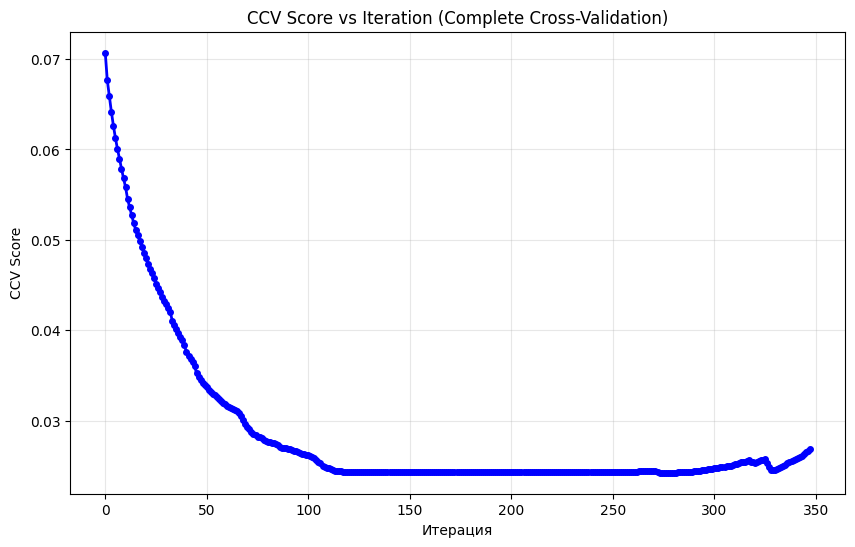

In [6]:
prototype_selector = PrototypeSelector(X_train, y_train, k=best_k)

prototypes, prototype_labels, prototypes_indices = prototype_selector.select_prototypes()

print(f"\nРезультаты отбора эталонов:")
print(f"  Исходное количество объектов: {len(X_train)}")
print(f"  Количество выбранных эталонов: {len(prototypes)}")

# Визуализация CCV, нормально ли, что начинается с большого значения?
plt.figure(figsize=(10, 6))
plt.plot(prototype_selector.ccv_scores, 'b-', linewidth=2, marker='o', markersize=4)
plt.xlabel('Итерация')
plt.ylabel('CCV Score')
plt.title('CCV Score vs Iteration (Complete Cross-Validation)')
plt.grid(True, alpha=0.3)
plt.show()

Сравнение реализаций алгоритма метрической классификации KNN

1. Без отбора эталонов
2. С отбором эталонов
3. С помощью библиотеки sklearn

In [11]:
model_full = KNNParzen()
model_full.fit(X_train, y_train)
y_pred_full = model_full.predict_variable_window(X_test, k=best_k)

model_prototype = KNNParzen()
model_prototype.fit(prototypes, prototype_labels)
y_pred_prototype = model_prototype.predict_variable_window(X_test, k=best_k)  

sklearn_knn = KNeighborsClassifier(n_neighbors=best_k)
sklearn_knn.fit(X_train, y_train)
y_pred_sklearn = sklearn_knn.predict(X_test)

Полученные метрики

In [13]:
prototype_acc = accuracy_score(y_test, y_pred_prototype)
prototype_precision = precision_score(y_test, y_pred_prototype, pos_label=1)
prototype_recall = recall_score(y_test, y_pred_prototype, pos_label=1)
prototype_f1 = f1_score(y_test, y_pred_prototype, pos_label=1)

custom_acc = accuracy_score(y_test, y_pred_full)
custom_precision = precision_score(y_test, y_pred_full, pos_label=1)
custom_recall = recall_score(y_test, y_pred_full, pos_label=1)
custom_f1 = f1_score(y_test, y_pred_full, pos_label=1)

sklearn_acc = accuracy_score(y_test, y_pred_sklearn)
sklearn_precision = precision_score(y_test, y_pred_sklearn, pos_label=1)
sklearn_recall = recall_score(y_test, y_pred_sklearn, pos_label=1)
sklearn_f1 = f1_score(y_test, y_pred_sklearn, pos_label=1)

print(f"\n{'Метрика':<20} {'prototype KNN':<15} {'custom KNN':<15} {'sklearn KNN':<15}")
print("-" * 50)
print(f"{'Accuracy':<20} {prototype_acc:<15.4f} {custom_acc:<15.4f} {sklearn_acc:<15.4f}")
print(f"{'Precision':<20} {prototype_precision:<15.4f} {custom_precision:<15.4f} {sklearn_precision:<15.4f}")
print(f"{'Recall':<20} {prototype_recall:<15.4f} {custom_recall:<15.4f} {sklearn_recall:<15.4f}")
print(f"{'F1-score':<20} {prototype_f1:<15.4f} {custom_f1:<15.4f} {sklearn_f1:<15.4f}")

print(f"\nConfusion Matrix - Prototype KNN Parzen (k={best_k}):")
print(confusion_matrix(y_test, y_pred_prototype))
print(f"\nConfusion Matrix - Custom KNN Parzen (k={best_k}):")
print(confusion_matrix(y_test, y_pred_full))
print(f"\nConfusion Matrix - sklearn KNN (k={best_k}):")
print(confusion_matrix(y_test, y_pred_sklearn))


Метрика              prototype KNN   custom KNN      sklearn KNN    
--------------------------------------------------
Accuracy             0.9591          0.9708          0.9708         
Precision            0.9903          0.9725          0.9725         
Recall               0.9444          0.9815          0.9815         
F1-score             0.9668          0.9770          0.9770         

Confusion Matrix - Prototype KNN Parzen (k=10):
[[ 62   1]
 [  6 102]]

Confusion Matrix - Custom KNN Parzen (k=10):
[[ 60   3]
 [  2 106]]

Confusion Matrix - sklearn KNN (k=10):
[[ 60   3]
 [  2 106]]


Алгоритм отбора эталонов позволяет значительно сократить размер обучающей выборки при незначительной потере качества классификации.